In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tvd
from riemann import shallow_roe_1D, shallow_hll_1D

plt.rcParams["figure.figsize"] = (20,9)
plt.rcParams['font.size'] = '16'

In [4]:
# nastavení parametrů
# constants
grav = 9.81

# domain
# x-coordinate, centered around 0
x_start = -.5
x_end = -x_start

# number of volumes for x and t 
N = 80
Nt = 400 

# size of spatial and time steps
dx = (x_end-x_start)/N # 0.005 #
dt = 0.0001
dtdx = dt/dx

# x axis for plots
x = np.linspace(x_start, x_end, N)

# problem_data
problem_data = {'grav' : grav,
               'efix' : False}

# initial condition setup
# tohle chce předělat na nějaké obecnější funkce
def shallow_ic(N, ic_type=1):
    '''
    Initial condition type:
    
    1 ... step in half domain
    2 ... 2 steps in domain
    3 ... sinus
    '''
    
    q_state = np.zeros([2,N])
    
    if ic_type == 3:
        q_state[0,:] = .1 * np.sin(np.linspace(0,4*np.pi,N)) +1
        
    elif ic_type == 2:
        for i in range(N):
            if i < N/3:
                q_state[0,i] = 5
            elif N/3 <= i < 2*N/3:
                q_state[0,i] = 3
            else: 
                q_state[0,i] = 1
            
    else:
        q_state[0,0:int(N/2)] = 4
        q_state[0,int(N/2):] = 1

    return q_state

# shallow water system solution
def shallow_sol(q_state, 
                Nt, 
                problem_data, 
                dtdx, 
                riemann_solver=shallow_roe_1D,
                higher_order = False,
                limiter = tvd.minmod,
                plot_sol=False):
    
    # initial condition plot
    if plot_sol:
        plt.subplot(1, 2, 1)
        plt.plot(x, q_state[0,:], 'bx:')
        plt.subplot(1, 2, 2)
        plt.plot(x, q_state[1,:], 'rx:')
        plt.show()
    
    aux_l, aux_r = 0, 0
    limiters = np.full(N,limiter)
    
    #maximalni rychlost
    s_max = np.zeros(Nt)
    
    # iterate solution for Nt time steps
    for i in range(Nt):
        q_l = q_state[:,:-1]
        q_r = q_state[:,1:]

        # solve Riemann problems at all faces 
        wave, s, amdq, apdq = riemann_solver(q_l, q_r, aux_l, aux_r, problem_data)
        s_max[i] = np.nanmax(np.abs(s))

        # update state with Riemann solutions
        q_state[:,:-1] = q_state[:,:-1] - dtdx * amdq
        q_state[:,1:] = q_state[:,1:] - dtdx * apdq
        
        # in case of higher order solution
        if higher_order:
            dtdx_array = np.full(N, dtdx)

            #wave limiting
            wave_lim = tvd.limit(2,wave,s,limiters,dtdx_array)
            
            F = np.zeros([2,N-1])
            w_num = wave.shape[1]
            
            #fluctuation correction F calculation
            F[0,:] = 1/2. * np.sum(np.abs(s)*(1-dtdx*np.abs(s))*wave_lim[0,:,:],axis=0)
            F[1,:] = 1/2. * np.sum(np.abs(s)*(1-dtdx*np.abs(s))*wave_lim[1,:,:],axis=0)

            #fluctuation correction F added to state
            # takhle se mi to zdá správně, protože je to duhé F skutečně posunuté na i+1/2
            # sice to kmitá, ale to by asi mělo. A mělo by to jít vyrovnat pomocí jemnějšího dělení
            q_state[:,:-1] = q_state[:,:-1] + dtdx * F
            q_state[:,:-2] = q_state[:,:-2] - dtdx * F[:,1:]

    print(f'N: {N}, Nt: {Nt}, dx: {dx}, dt: {dt}, CFL: {np.max(s_max)*dtdx}')
    
    # solution plot 
    if plot_sol:
        plt.subplot(1, 2, 1)
        plt.plot(x, q_state[0,:], 'bx:')
        plt.subplot(1, 2, 2)
        plt.plot(x, q_state[1,:], 'rx:')
        plt.show()
    
    return q_state
        
    

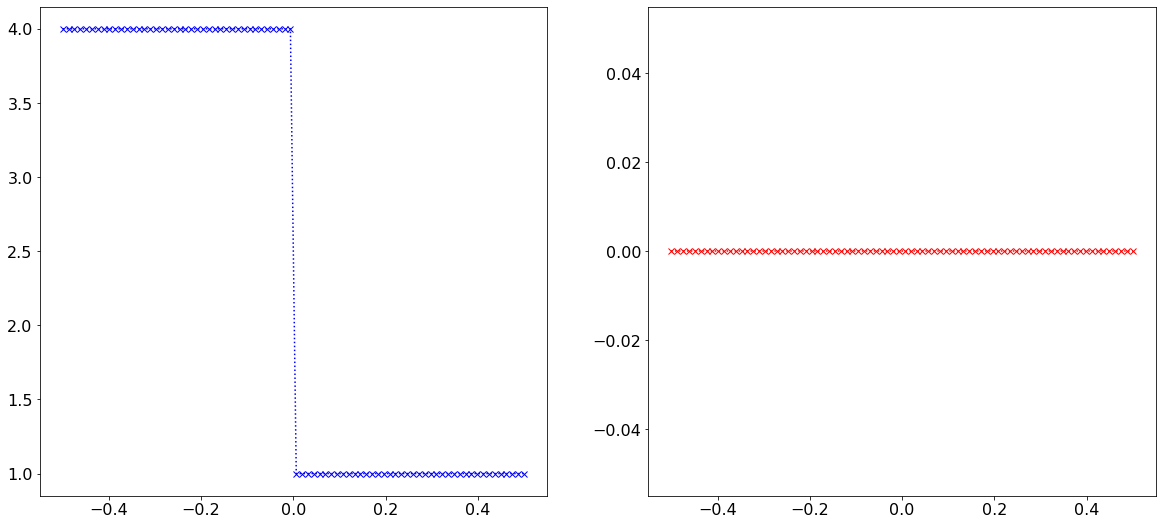

N: 80, Nt: 400, dx: 0.0125, dt: 0.0001, CFL: 0.06300837423010058


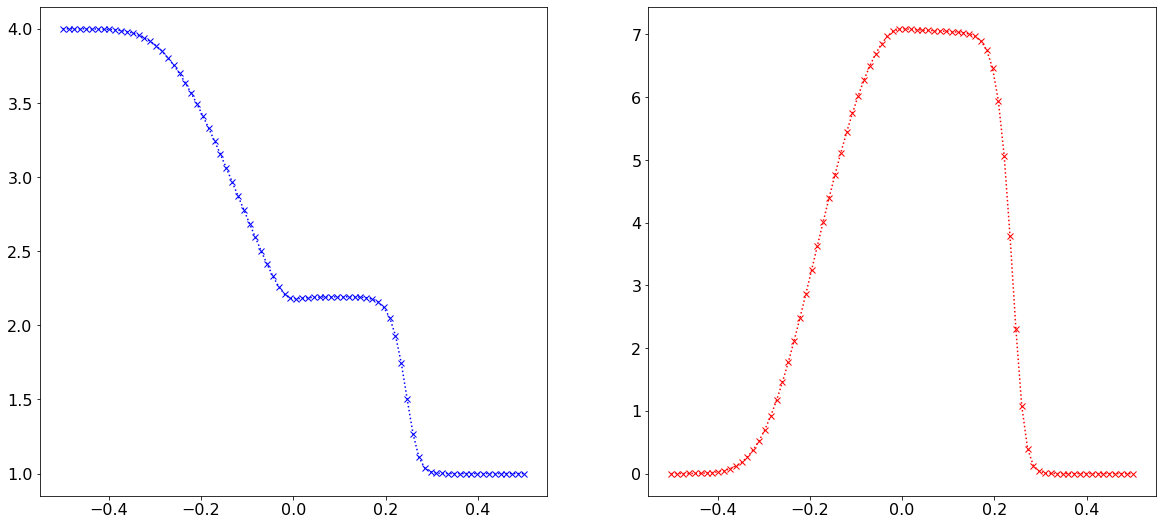

In [5]:
# 1st order, Roe Riemann solver
Q = shallow_ic(N, 1)
Q_roe = shallow_sol(Q, Nt, problem_data, dtdx, plot_sol=True)

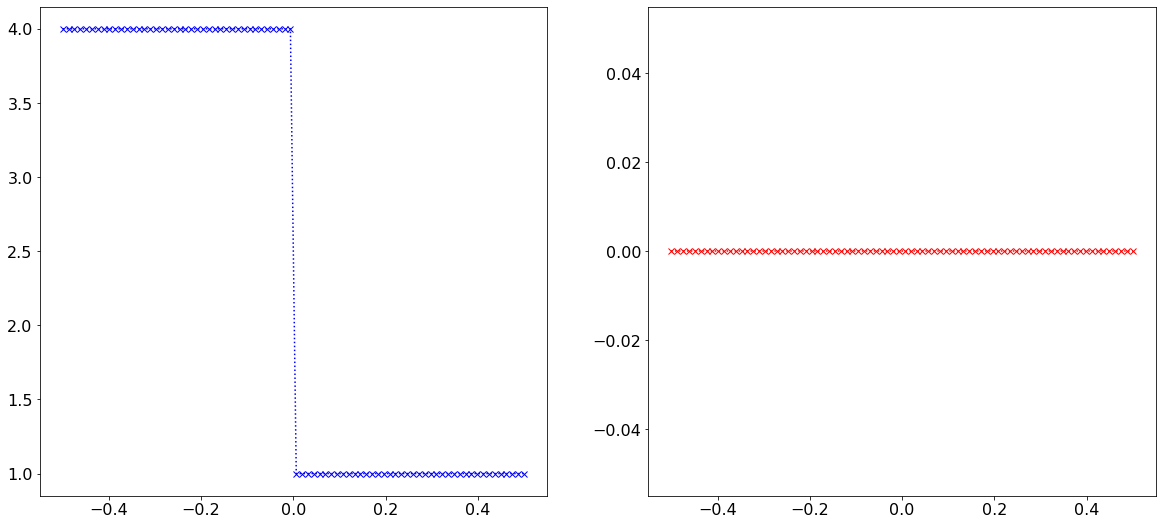

N: 80, Nt: 400, dx: 0.0125, dt: 0.0001, CFL: 0.06296422218543672


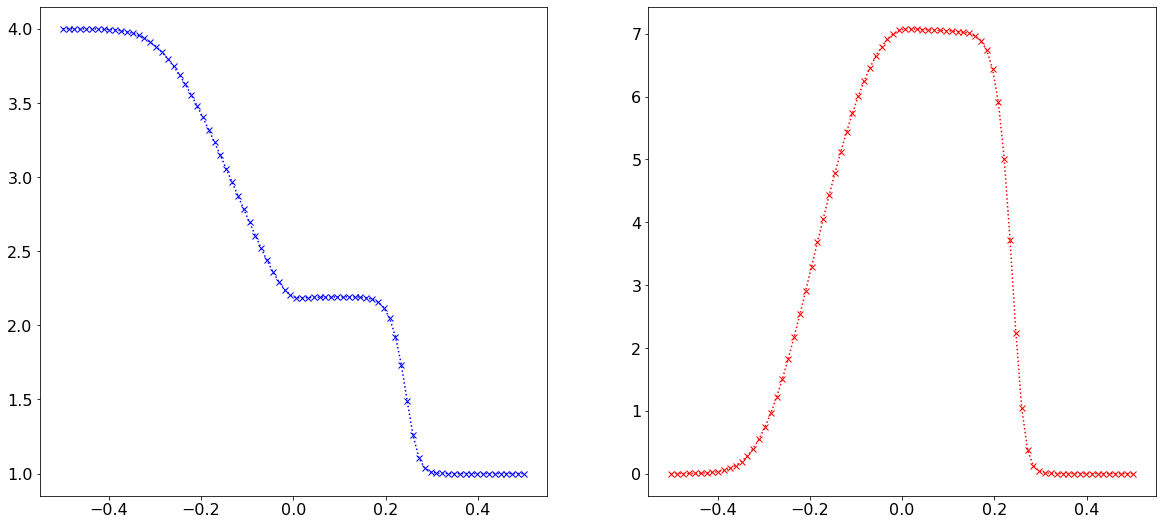

In [6]:
# 1st order, hll Riemann solver
Q = shallow_ic(N, 1)
Q_hll = shallow_sol(Q, Nt, problem_data, dtdx, riemann_solver=shallow_hll_1D, plot_sol=True)

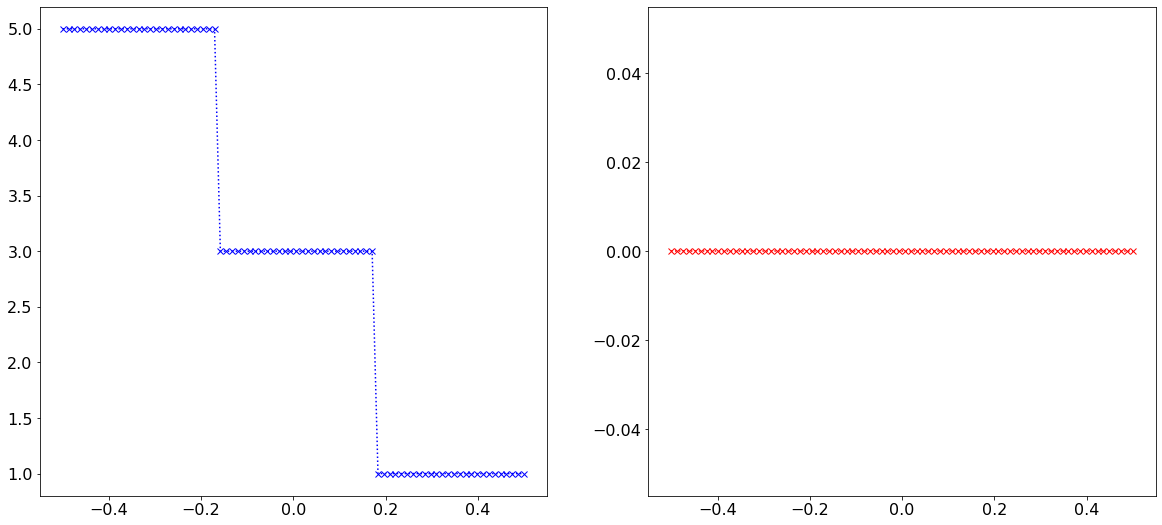

N: 80, Nt: 400, dx: 0.0125, dt: 0.0001, CFL: 0.07095583627106901


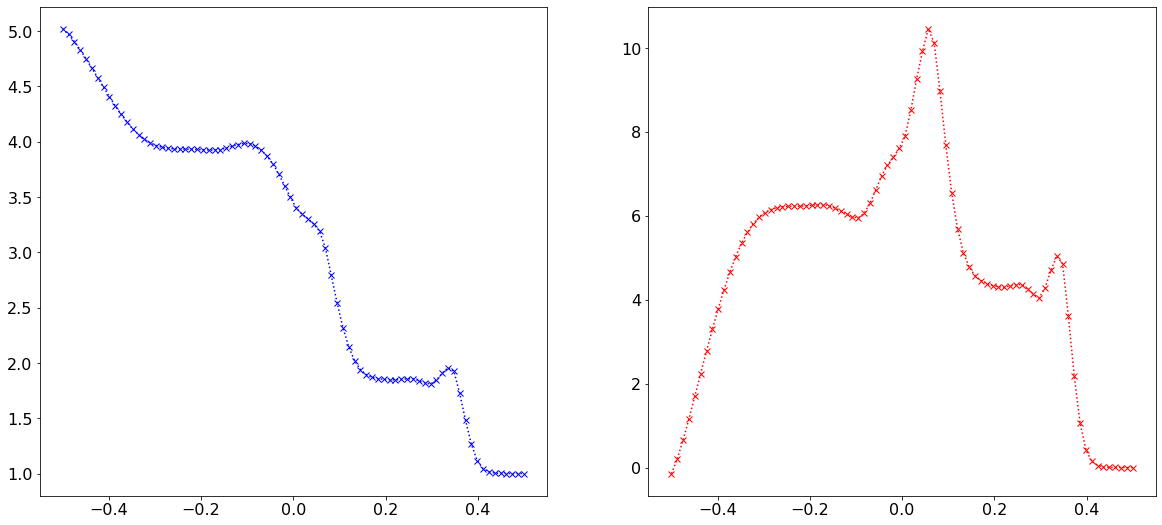

In [10]:
# 2nd order, hll Riemann solver, minmod limiter
Q = shallow_ic(N, 2)
Q_hll_minmod = shallow_sol(Q, Nt, problem_data, dtdx, riemann_solver=shallow_hll_1D, higher_order = True, plot_sol=True)

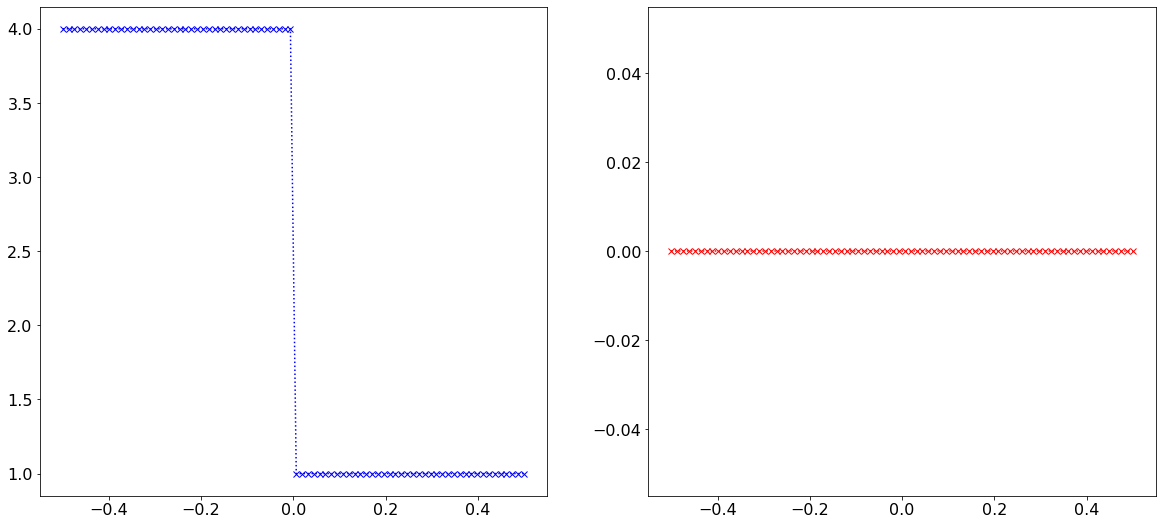

N: 80, Nt: 400, dx: 0.0125, dt: 0.0001, CFL: 0.07054111652991539


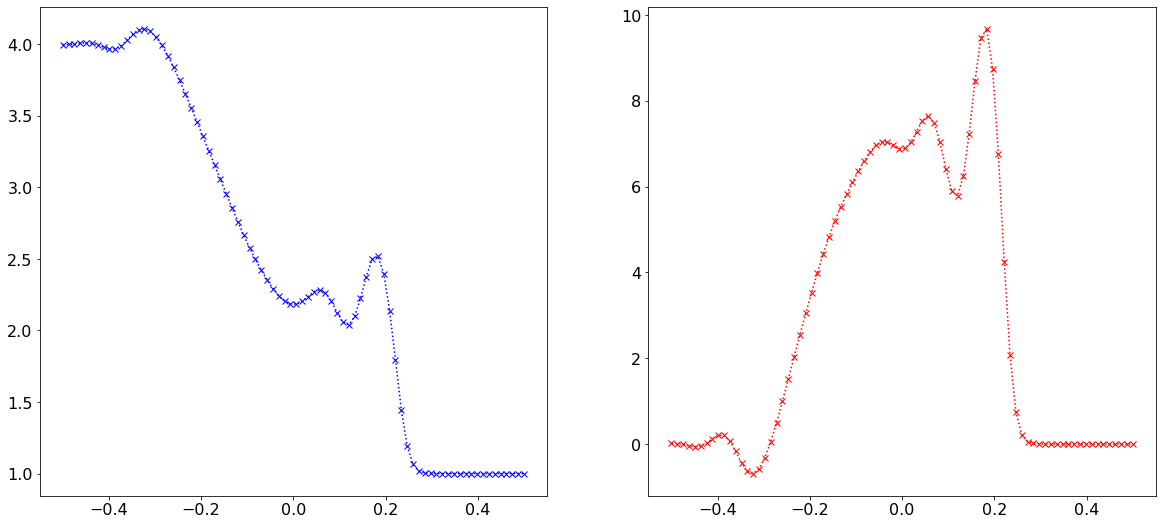

In [8]:
# 2nd order, hll Riemann solver, Arora-Roe limiter
Q = shallow_ic(N, 1)
Q_hll_arora = shallow_sol(Q, Nt, problem_data, dtdx, riemann_solver=shallow_hll_1D, higher_order = True, limiter=tvd.arora_roe, plot_sol=True)

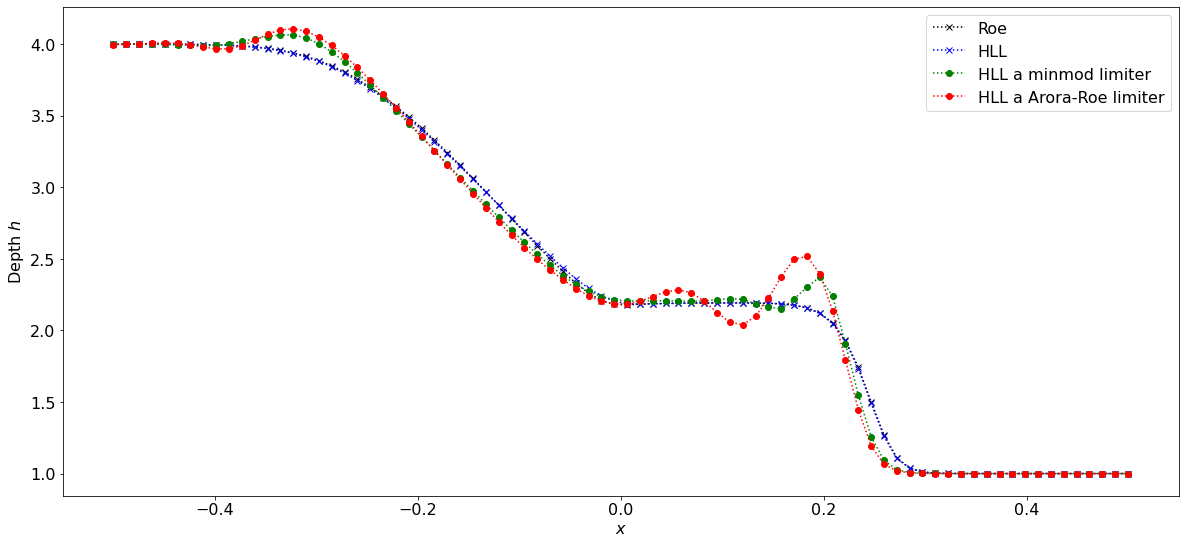

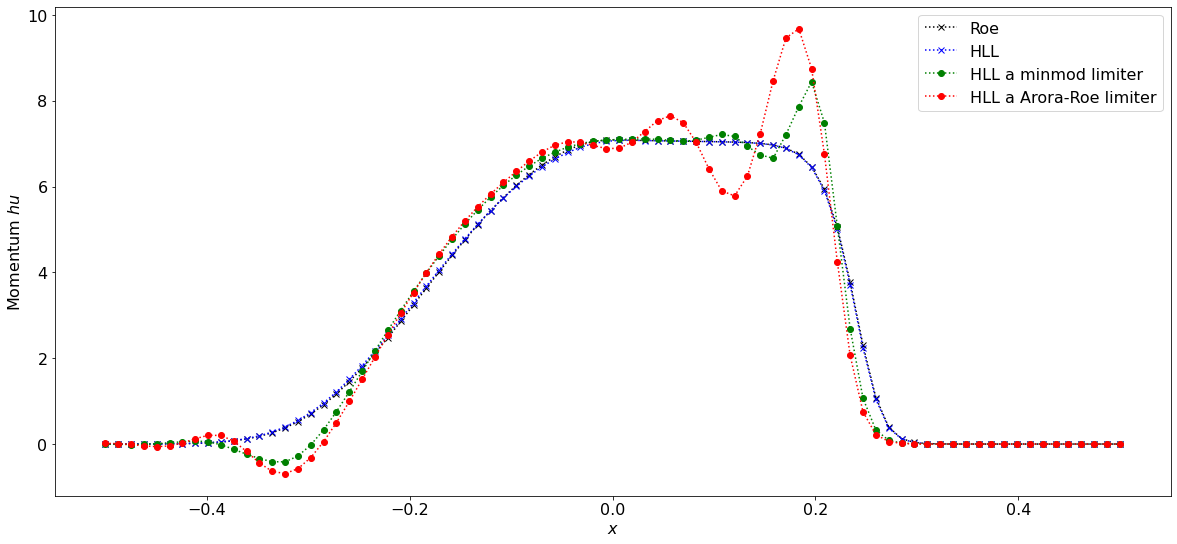

In [9]:
#plt.subplot(1, 2, 1)
plt.plot(x, Q_roe[0,:], 'kx:', label='Roe')
plt.plot(x, Q_hll[0,:], 'bx:', label='HLL')
plt.plot(x, Q_hll_minmod[0,:], 'go:', label='HLL a minmod limiter')
plt.plot(x, Q_hll_arora[0,:], 'ro:', label='HLL a Arora-Roe limiter')
plt.legend()
plt.ylabel('Depth $h$')
plt.xlabel('$x$')
plt.show()
#plt.subplot(1, 2, 2)
plt.plot(x, Q_roe[1,:], 'kx:', label='Roe')
plt.plot(x, Q_hll[1,:], 'bx:', label='HLL')
plt.plot(x, Q_hll_minmod[1,:], 'go:', label='HLL a minmod limiter')
plt.plot(x, Q_hll_arora[1,:], 'ro:', label='HLL a Arora-Roe limiter')
plt.ylabel('Momentum $hu$')
plt.xlabel('$x$')
plt.legend()
plt.show()

hsjahfjsdkfhfdiksdfi